https://arxiv.org/abs/2305.14314 (original paper) <br/>
https://github.com/artidoro/qlora (qlora official github repo) <br/>
https://github.com/TimDettmers/bitsandbytes (bitsandbytes github 8-bit quantisation technique) <br/>
https://github.com/huggingface/peft (hugging face fine-tuning lib) <br/>
https://en.wikipedia.org/wiki/Quantile (quantile) <br/>
https://timdettmers.com/2022/08/17/llm-int8-and-emergent-features/ (blog: quantization overview) <br/>
https://docs.nvidia.com/deeplearning/tensorrt/tensorflow-quantization-toolkit/docs/docs/intro_to_quantization.html (basics of general quantization). <br/>
https://www.youtube.com/watch?v=jyOqtw4ry2w (author video; tim dettmers) <br/>
https://www.youtube.com/watch?v=AlASZb93rrc (quantization lecture 1 by han from tinyMl) <br/>
https://www.youtube.com/watch?v=sYpl97ToNdg (quantization lecture 2 by han from tinyMl) <br/>
https://www.youtube.com/watch?v=EsMcVkTXZrk (tim detmerrs in stanford) <br/>
https://www3.ntu.edu.sg/home/ehchua/programming/java/datarepresentation.html (digital data representation basics) <br/>

https://arxiv.org/pdf/2208.07339.pdf (LLM.int8() inference time 8bit mixed precision quantizaiton) <br/>
https://arxiv.org/pdf/2110.02861.pdf (block wise quantization for optimizers state) <br/>
https://arxiv.org/pdf/2306.03078.pdf (3-4 bit mixed quantization for edge devices) <br/>
https://arxiv.org/abs/2210.17323 (post training quantization for gpt's) <br/>
https://arxiv.org/pdf/2004.09602.pdf (general principle on quantization by nvidia) <br/>
https://arxiv.org/pdf/2106.08295.pdf (neural network quantization by qualcomm) <br/>
https://www.youtube.com/watch?v=fQirE9N5q_Y (lecture by tim) <br/>

------

```python
* how to think about memory footprint in models

```

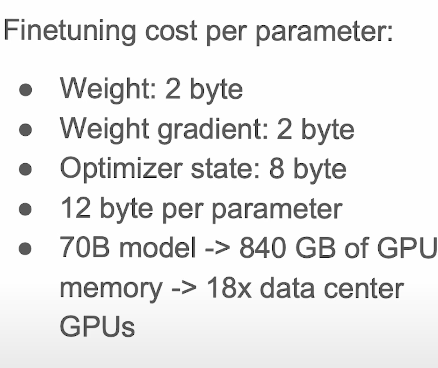

```python

* role of paged optimizers

```

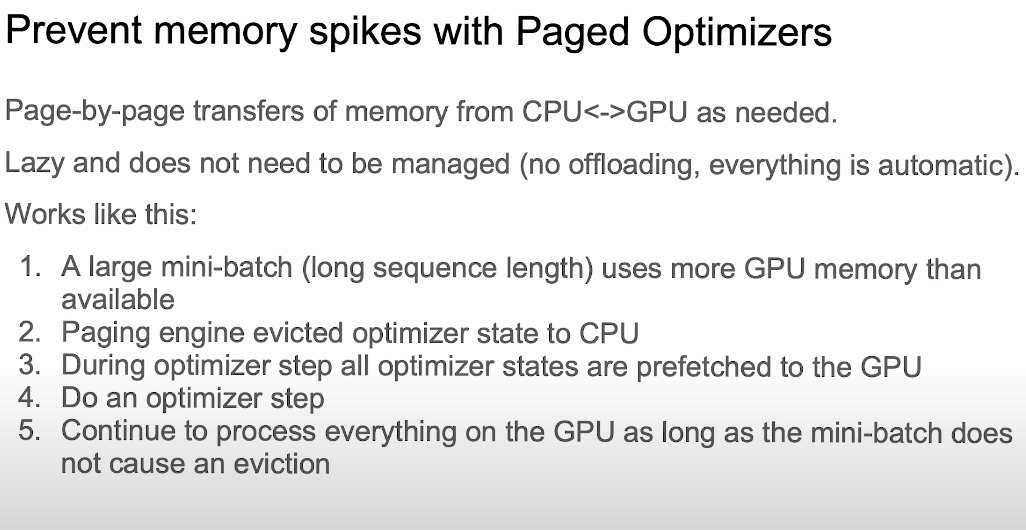

```python
* double quantization process

```

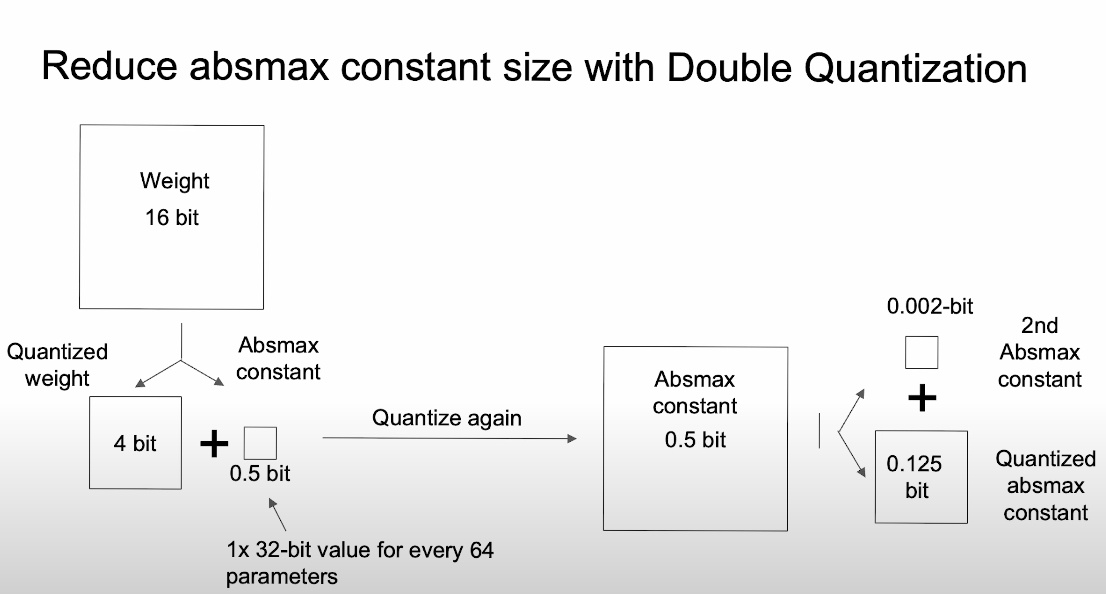

```python
* nf4 data type scheme

* note (quantile function in paper basically means z-score function)

```

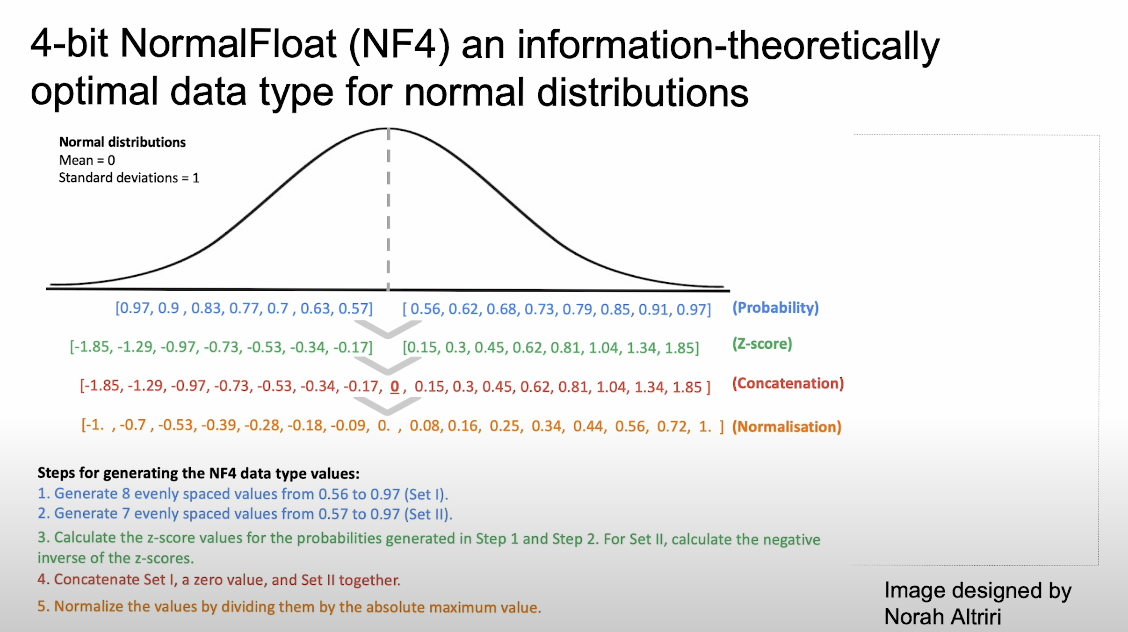

```python

# need to know:

* what is the impact on precision by exponent and fraction in floating point numbers.
* dynamic exponent quantization data type.
* block wise quantization.
* k-bit inference scaling law (4-bit scales well with parameters).
* block size impact on (quantization block size) scaling.
* pythia (https://github.com/EleutherAI/pythia).

```



```python
# motivation:

* LLaMA 65B requires ~780GB GPU memory.🥵
* same model with qlora techniques can run on ~48GB single GPU memory.
* can be trained within 24 hrs time.

```

In [24]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np

```python
# quantization:

* basics idea is to convert high range values like fp32 to low range value like int8.
* the reason we do this primarily because of the memory footprint and computational cost of 
  some of the large models requires to run is huge. and this makes it hard to run or fine tune these
  large models with reasonable price. 
* quantization solve this by reducing the bits required to store these weights.
* but its not enough to just reduce the bits, model should be able to perform at the same level as it's 
  high bit range counter parts.

```

```python

# general quantization process:

* convert the target lower bit width into the range [-1, 1].
* convert the input higher bit width into the range [-1, 1].
* use binary search between target and input range and match the closest with each other.
* now we have mapping between lower bits to higher input bits.

```

In [4]:
def calc_memory(x, label='x'):
    memory_of_x = round((x.element_size() * x.numel())/(1024**2))
    print(f"{label} memory: {memory_of_x} MB  ({x.dtype})", )
    return memory_of_x

def dequantize_error(input_x, de_quantized_x):
    abs_err = (input_x-de_quantized_x).abs().mean().item()
    print(f"de-quantized mean abs error: {abs_err:.3f}")
    return abs_err

def memory_reduction(input_x, quantized_x):
    m_x = calc_memory(input_x, label='original')
    m_q = calc_memory(quantized_x, label='quantized')
    
    print(f"quantized {round(m_x/(m_q or 1))}x less memory")

# general quantize and dequantize process
def quantize(x, b, bdytpe):
    q_scale = (2**(b-1)-1)/x.abs().max().item() 
    quantized_x = (x * q_scale).round()
    return q_scale, quantized_x.to(dtype=bdytpe)

def de_quantize(quantized_x, q_scale):
    de_quantized_x = quantized_x/q_scale
    return de_quantized_x.to(dtype=torch.float32)

In [11]:
def run_quantization(input_x, quantize, de_quantize, b=8, bdytpe=torch.int8, max_range=10):
    
    # quantize
    q_scale, quantized_x = quantize(input_x, b, bdytpe)

    # de-quantize
    de_quantized_x =  de_quantize(quantized_x, q_scale)

    # de-quantize error
    dequantize_error(input_x, de_quantized_x)

    # memory footprint
    memory_reduction(input_x, quantized_x)

    # plot dist
    original_dist = torch.histogram(input_x)
    dequantized_dist = torch.histogram(de_quantized_x)
    quantized_bins =  torch.unique(quantized_x, return_counts=True)


    _, axs = plt.subplots(1, 2, figsize=(15, 4))
    _, axs_bins = plt.subplots(figsize=(15, 4))
    axs[0].bar(original_dist[1][1:], original_dist[0], label='original');
    axs[1].bar(dequantized_dist[1][1:], dequantized_dist[0], label='de-quantized', color='orange');
    axs_bins.bar(quantized_bins[0].numpy(), quantized_bins[1].numpy(), label='quantized bins', color='green');

    prop_non_occupied_bins = (1-(len(quantized_bins[0])/(2**(b)-2)))
    print(f"non occupied quantized bins: {round(prop_non_occupied_bins*100)}%", )

    
    max_range = 10
    axs[0].set_xlim([-max_range, max_range])
    axs[1].set_xlim([-max_range, max_range])

    axs[0].legend();
    axs[1].legend();
    axs_bins.legend();
    plt.show();
    

de-quantized mean abs error: 0.010
original memory: 38 MB  (torch.float32)
quantized memory: 10 MB  (torch.int8)
quantized 4x less memory
non occupied quantized bins: 5%


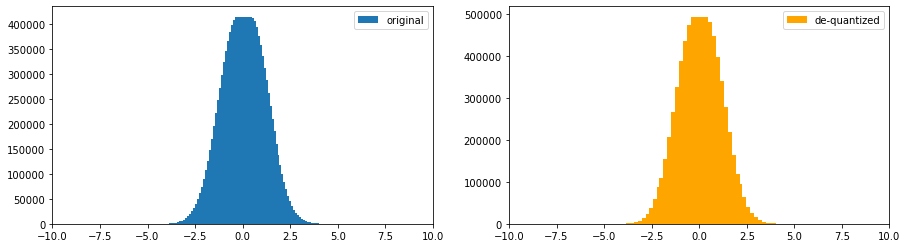

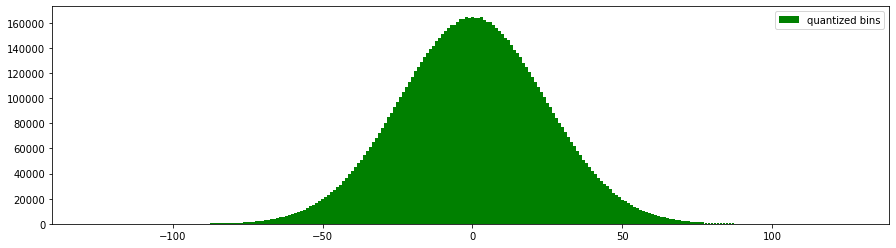

CPU times: user 3.09 s, sys: 607 ms, total: 3.69 s
Wall time: 1.02 s


In [12]:
torch.manual_seed(42)

# quantization process:
input_x = torch.randn(10000000)

bit_sz = 8
bdytpe = torch.int8

%time run_quantization(input_x, quantize, de_quantize, bit_sz, bdytpe)

de-quantized mean abs error: 0.098
original memory: 38 MB  (torch.float32)
quantized memory: 10 MB  (torch.int8)
quantized 4x less memory
non occupied quantized bins: 89%


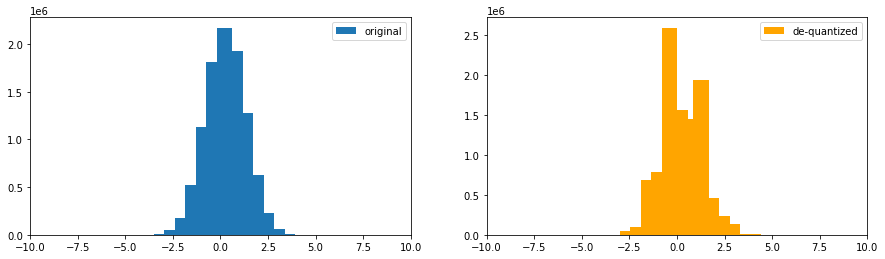

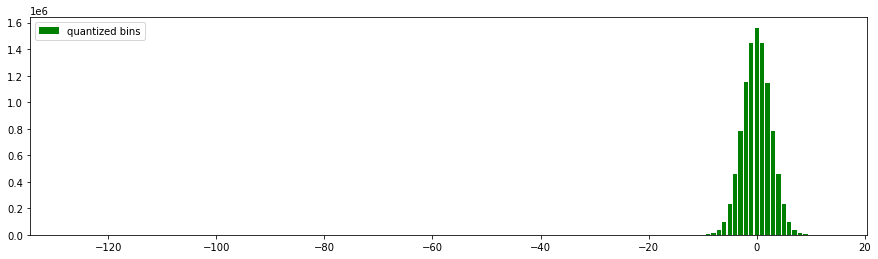

CPU times: user 2.57 s, sys: 506 ms, total: 3.07 s
Wall time: 780 ms


In [18]:
# quantization with outliers:
# increased abs error: ~10x higher compared to inputs without outliers.
# quantized bins are not utilized properly: ~90% bins are not utilized.

torch.manual_seed(42)

input_x = torch.cat([torch.randn(10000000), torch.tensor([-50])])

bit_sz = 8
bdytpe = torch.int8

%time run_quantization(input_x, quantize, de_quantize, bit_sz, bdytpe)

de-quantized mean abs error: 0.016
original memory: 4 MB  (torch.float32)
quantized memory: 1 MB  (torch.int8)
quantized 4x less memory
non occupied quantized bins: 0%


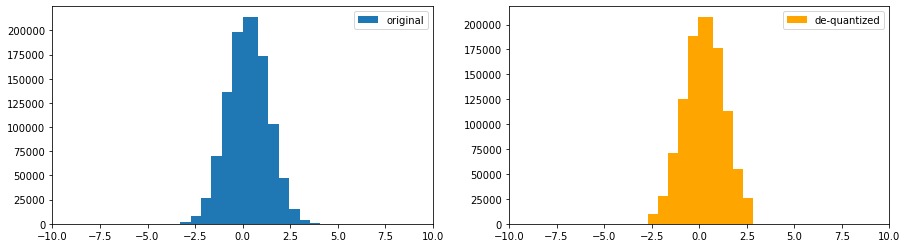

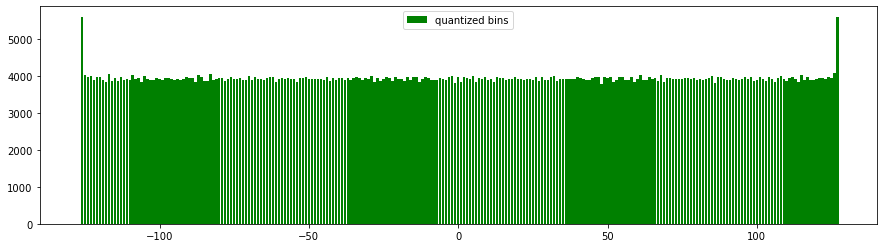

CPU times: user 4.43 s, sys: 2.97 s, total: 7.4 s
Wall time: 2.09 s


In [23]:
# all bins are equally occupied.
# quantile quantization is too slow.
# todo: need to verify this.

# calc inputs cdf: 
# 1. sort the input array.
# 2. use quantie_percet_i * len(input_x) = input_quantile_val.
# 3. do binary search against this k input quantile val against all the inputs to find nearby val.


input_x = torch.cat([torch.randn(1000000), torch.tensor([-50])])

n = len(input_x)
bit_sz = 8
bit_dtype = torch.int8


def quantile_quantize(x, b, bdytpe):
    bit_width = (((2**b)-1))
    quantiles_percent = torch.arange(0, bit_width)/bit_width

    input_x = x.clone()
    input_x = input_x.sort()[0]
    input_quantile_val = torch.stack(list(input_x[int(q*len(input_x))] for q in quantiles_percent))
    quantized_idx = (x[:,None] - input_quantile_val).abs().argmin(dim=-1)
    
    return input_quantile_val, quantized_idx.to(dtype=bdytpe)-(2**(b-1)-1)


def quantile_de_quantize(quantized_x, q_scale):
    de_quantized_x = q_scale[(quantized_x+127).to(dtype=torch.long)]
    return de_quantized_x.to(dtype=torch.float32)
    
    
%time run_quantization(input_x, quantile_quantize, quantile_de_quantize, bit_sz, bdytpe)

------

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


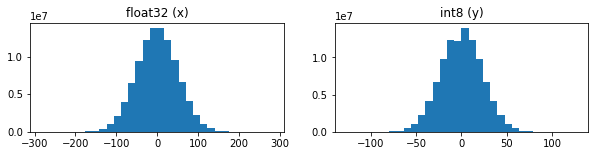

In [132]:
# todo: name may be different need to check
# todo: example need to be verified
# linear quantisation:
# naive 8bit int quantisation from float32 bit.
# element_size: returns bytes of each element in the tensor.
# numel: returns number of elements.
# memory is reduced drastically.
# at the same time distribution is sort of intact.

x = torch.randn(100000000) * 50
memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(10, 2))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=32)
    ax.set_title(title)
plt.show();

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


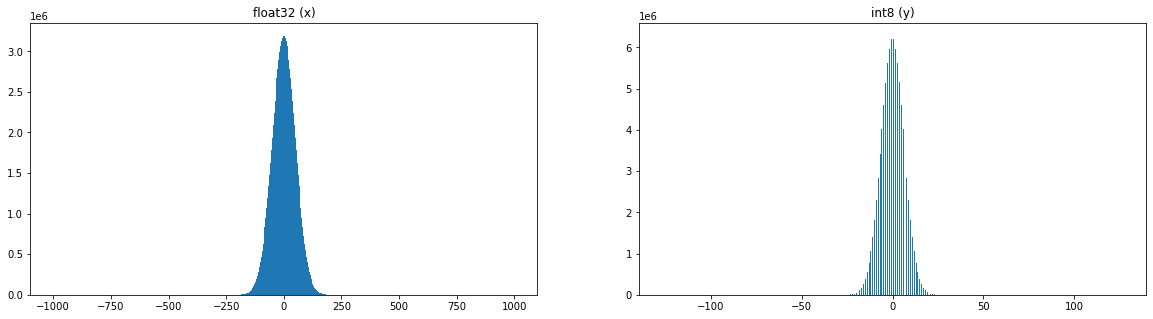

In [133]:
# failure case when there are outliers. then this technique dosn't properly preserve the distributions.
# white strip is the missing bins this happens due to this outlier and eneven property of the input data.

# big outlier issue: normal distribution (scaled with 5) is concated with extreme outlier value of 1000.
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])

# narrow range issue: this is narrow range issue example.
# x = torch.randn(100000000) * 0.01

memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


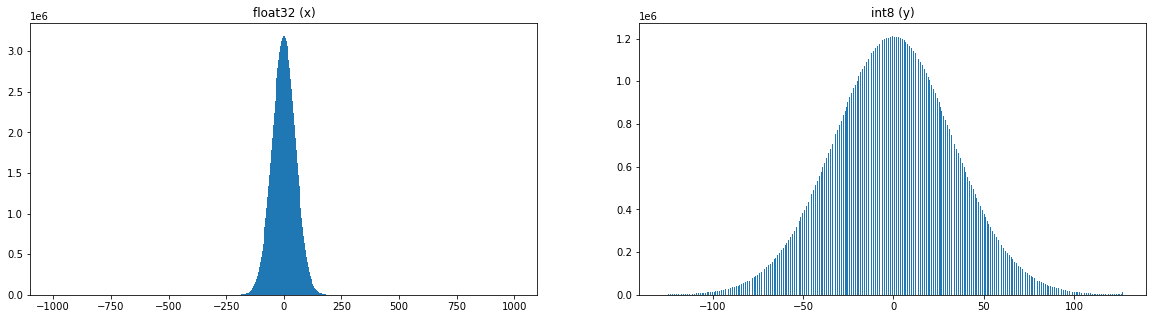

In [134]:
# block-wise k-bit quantisation:
# split the input into buckets and run the naive quantisation on those bucket,
# this will help to side step from the outlier issues.

def quantise(x):
    abs_max_x = x.max().abs()
    return (127 * (x/abs_max_x)).round().to(torch.int8)

block_size = 10000
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")

x_chunked_lst = x.chunk(block_size)
x_chunked_lst_quantised = map(quantise, x_chunked_lst)

y = torch.cat(list(x_chunked_lst_quantised))
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

In [135]:
# gradient memory foot print issue:
# in parameter efficient fine tuning like lora, main memory increase not in actual lora paramerts but 
# instead of gradient memory during backprop.
# e.g. 7B LLaMA with batch size of 1 and lora weight == 0.2% of the original weight only takes ~25MB but 
# it's gradient takes ~567MB memory!.

In [136]:
# 4-bit normal float quantisation:
# build on top of "quantile quantization" technique, this ensures each bin equal number of items assigned.
# "k-quantiles" buckets set of items into almost equal number in k bcuket. 
# some common quantiles are "quartiles (4 groups), percentile (100 groups)".

CPU times: user 1.64 s, sys: 413 ms, total: 2.05 s
Wall time: 1.67 s


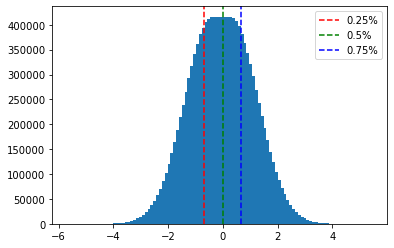

In [332]:
# SRAM-quantiles: fast quantile estimation algo:
# usual slow quantile estimation which uses logn to sort, for 10^8, it takes 1.37s.
# here sorting is slow because, it involves repeated store and load from DRAM.
# it uses GPU SRAM (known as shared memory). which is "15x" faster thant DRAM!.
# one issue is it has only 64kb per core.
# fast quantile estimation algo which chunk the big tensor such that each chunk fit into SRM and
# calculate cdf independently for each chunk on SRAM, then finally take average the quantiles on DRAM.
# todo: check how average is done??
# todo: need to check algo and check on GPU??

x = torch.randn(10000000)
n = len(x)
%time x = x.sort()[0] # nlogn 

# now for required quanitle, use : quantile index = quntaile % * len(x)
# this is usual way to get quantiles.
quartiles = [0.25, 0.5, 0.75]
quartiles_val = list(x[int(n*q)] for q in quantiles)

# plot quantiles on histogram
hist = torch.histogram(x)
plt.bar(hist[1][:-1], hist[0]);
for c, qv, lbl in zip(['r','g','b'], quartiles_val, quartiles):
    plt.axvline(qv, color=c, linestyle='--', label=f"{str(lbl)}%")
plt.legend();

In [336]:
# 4-bit normal float quantisation
# https://twitter.com/Tim_Dettmers/status/1661379379333681152 (ref)
# it trys to sequeze in higher precision data types FP16 to lower precision data types 4-bit in a such a way
# that each available entries in 4-bit occupied by the same number of items from the FP16. e.g. 5 items of 
# the F16 are sequezed into single position in 4-bit (beacause of the less space in 4bit), 
# this normal float quantisation technique ensures that all possition are sequezed with same number of items 
# around 5 items from F16.
# this is achievable due the property that trained neural network weights are more or less normaly distributed
# centered around mean.
# one interesting property of the weights which are distributed as standard normal distribution is that
# you can capture all kind of weight distribution by scaling with their respective standard deviation.

In [354]:
# quantization general formula:
# quantized_x = clamp(round(x/scale) + zero_point).
# scale = (beta - alpha) / (2^b - 1)
# [alpha, beta]: range of x.
# (2^b - 1): max range of target low precision, b-bits (e.g., 8 bits range = 255).
# zero_point = -round(beta * scale) - 2^(b-1); basically shifting the full range to zero-centered.

# dequantization:
# x = (quantized_x - zero_point)*scale.

In [363]:
# symmetric uniform quantization:
# the idea here is to keep the same number of elements between the negative and positive sides around zero. if
# we don't do this then it will create asymmetric quantization.
# for example, in 8 bits, we only consider the range [-127, 127]. We ignore one value for symmetry, implying our zero_point = 0.
# the simplified formula is quantized_x = clamp(round(x / scale)).
# scale = max_x / (2^(b-1)), where max_x = max(abs(alpha), abs(beta)).
# dequantization: x = quantized_x * scale.

x_memory: 38.1470 MB
quantized_x_memory: 9.5367 MB
quantized memory is 4 times lower than original input x
mse error:  0.00014


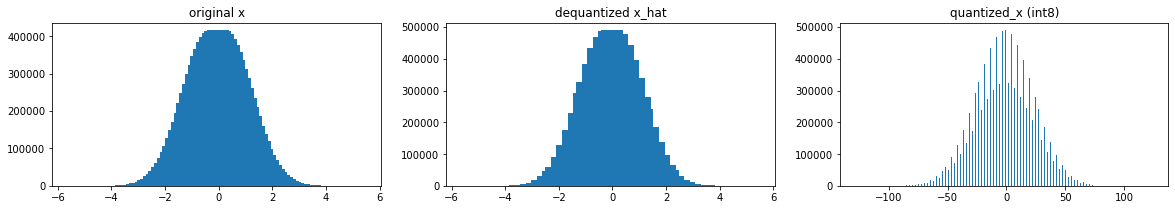

In [491]:
# torch.histogram doesn't works on int8 dtype.
# https://www.linkedin.com/advice/0/what-some-common-quantization-errors-how-can (error metrics)
torch.manual_seed(42)

def quantize(x, b):
    max_x = x.abs().max()
    scale = max_x/(2**(b-1))
    quantized_x = (x/scale).round()
    return quantized_x, scale

def dequantize(quantized_x, scale):
    return quantized_x * scale
    
x = torch.randn(10000000, dtype=torch.float32)
# x = torch.cat([torch.randn(100000, dtype=torch.float32), torch.tensor([25])])
# x = x.pow(2)

# quantize to 8-bit int from float32 bit
quantized_x, scale = quantize(x, 8)
quantized_x = quantized_x.to(dtype=torch.int8)

# dequantize from 8bit int to float32 bit
x_hat = dequantize(quantized_x, scale)
quantized_x, x_hat


# memory analysis
x_mem = (x.element_size() * x.numel())/(1024**2)
quantized_x_mem = (quantized_x.element_size() * quantized_x.numel())/(1024**2)
print(f'x_memory: {x_mem:.4f} MB')
print(f'quantized_x_memory: {quantized_x_mem:.4f} MB')
print(f'quantized memory is {(x_mem/quantized_x_mem):.0f} times lower than original input x')

# histogram analysis
_, axs = plt.subplots(1, 3, figsize=(20, 3))
for ax, xs, t in zip(axs, (x, x_hat, quantized_x), ('original x', 'dequantized x_hat', 'quantized_x (int8)')):
    hist = np.histogram(xs, bins=100)
    ax.bar(hist[1][:-1], hist[0])
    ax.set_title(t)

# mean squared error (MSE)
mse = (x-x_hat).pow(2).mean()
print('mse error: ', round(mse.item(), 5))

# todo: signal to noise ratio (SNR):
snr = None

# todo: peak signal to noise ratio (PSNR)
psnr = None


https://chat.openai.com/share/2adf7481-92a0-4e13-b0d1-1f5edf26d275 (chatgpt conv on floating point numbers)